Este notebook contiene un clasificador que se ha construido como una subclase de keras.Model. El objetivo de realizar este trabajo consiste en conocer algunas de las herramientas que ofrece Tensorflow para la construcción, entrenamiento y evaluación de redes neuronales.

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
def mnist_preprocessing(validation_size=10000, flatten=True):
    """Preprocesamiento del dataset MNIST para la clasificación de dígitos manuscritos.

    El dataset entrega las tuplas (x_train, y_train), (x_test, y_test) que contienen
    todas las muestras y etiquetas de MNIST. Cada imagen es de 28*28 pixeles en escala
    de grises, en donde cada pixel es un valor entero entre 0 y 255.

    x_train: uint8 NumPy array de dimensión (60000, 28, 28). Contiene 60_000 imágenes de
    dígitos para entrenamiento.

    y_train: uint8 NumPy array de dimensión (60000,). Contiene 60_000 enteros entre 0 y 9
    que indican el dígito al que corresponde la imagen con el mismo índice en x_train.
    
    x_test: uint8 NumPy array de dimensión (10000, 28, 28). Contiene 10_000 imágenes de
    dígitos para test.

    y_test: uint8 NumPy array de dimensión (10000,). Contiene 10_000 enteros entre 0 y 9
    que indican el dígito al que corresponde la imagen con el mismo índice en x_test.

    Parameters
    ----------
    validation_size : int
        Cantidad de muestras extraidas de (x_train, y_train) para destinarlas al conjunto
        de validación.
    flatten : bool
        Si flatten es True, cada imagen del dataset es redimensionada a un NumPy array
        unidimensional. De lo contrario, se preservan las dimensiones.
    
    Returns
    -------
    X_train, y_train, X_val, y_val, X_test, y_test
        Ejemplos y etiquetas separadas para entrenamiento, validación y test.
    """

    # Carga del dataset MNIST.
    mnist = keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalización de pixeles.
    X_train = x_train.astype(float)/255
    X_test = x_test.astype(float)/255

    # Separación de los conjuntos de entrenamiento y validación
    X_train, X_val = X_train[:-validation_size], X_train[-validation_size:]
    y_train, y_val = y_train[:-validation_size], y_train[-validation_size:]

    if flatten: # Convierte cada imagen a un array unidimensional.
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    
    # Convierte las etiquetas a formato one-hot encoding.
    lb = LabelBinarizer()
    lb.fit(y_train)
    y_train = lb.transform(y_train)
    y_val = lb.transform(y_val)
    y_test = lb.transform(y_test)
    

    return X_train, y_train, X_val, y_val, X_test, y_test


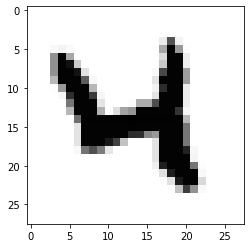

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist_preprocessing()
plt.imshow(X_train[20].reshape([28, 28]), cmap="Greys")


In [20]:
class MLPClassifier(keras.Model):
    """Wrapper para la clase Model de keras. Genera un perceptrón multicapa con las unidades entregadas.

    Attributes
    ----------
    input_shape : int
        Dimensión de la capa de entrada de la red.
    dropout : int o None
        Si es distinto de None, corresponde a la probabilidad usada en Dropout.
    layers_ : list(int)
        Lista con todas las capas de la red.
    optimizer : optimizer o str
        Optimizador para la retropropagación.
    loss : loss o str o None
        Función de pérdidas usada para la retropropagación.
    metrics_ : list(metrics o str) o None
        Métricas adicionales para la medición del rendimiento.
    callbacks : list(callbacks) or None.
        Callbacks usados por el modelo.
    epochs : int
        Cantidad de épocas durante el entrenamiento.
    """
    def __init__(
        self,
        input_shape,
        layers_units,
        optimizer="rmsprop",
        loss=None,
        metrics=None,
        dropout=None,
        callbacks=None,
        epochs=1,
        compiled=False
        ):
        """Define los atributos del modelo.

        Parameters
        ----------
        input_shape : int
            Dimensión de la capa de entrada de la red.
        layers_units : list(int)
            Lista con la cantidad de unidades en las capas ocultas y capa de salida.
        optimizer : optimizer o str, optional
            Optimizador para la retropropagación, por defecto es "rmsprop".
        loss : loss o str o None, optional
            Función de pérdidas usada para la retropropagación, por defecto es None.
        metrics : list(metrics o str) o None, optional
            Métricas adicionales para la medición del rendimiento, por defecto es None.
        dropout : int o None, optional
            Si es distinto de None, corresponde a la probabilidad de usada en Dropout,
            por defecto es None.
        callbacks : list(callbacks) or None, optional
            Callbacks usados durante el entrenamiento, por defecto es None.
        epochs : int, optional
            Cantidad de épocas durante el entrenamiento, por defecto es 1.
        compiled : bool, optional
            En caso de ser verdadero, se entrega el modelo compilado, mientras que
            de ser False el modelo se entrega sin compilar, por defecto es False.
        """

        super(MLPClassifier, self).__init__()

        self.input_shape_ = input_shape
        self.dropout = dropout
        self.layers_ = self._add_layers(layers_units)
        self.optimizer = optimizer
        self.loss = loss
        self.metrics_ = metrics
        self.callbacks = callbacks
        self.epochs = epochs

        if compiled:
            self.compile_model(optimizer=optimizer, loss=loss, metrics=metrics)

    
    def _add_layers(self, layers_units):
        """Crea las capas usadas por el modelo.

        Parameters
        ----------
        layers_units : list(int)
            Cantidad de unidades para cada capa oculta

        Returns
        -------
        layers : list(layers)
            Capas de la red neuronal.
        """

        num_layers = len(layers_units)
        layers = []

        # Primero se agrega la capa de entrada
        layers.append(keras.layers.InputLayer((self.input_shape_,), name="Input_Layer"))

        # Se generan las capas ocultas
        for i in range(num_layers - 1):
            layers.append(keras.layers.Dense(
                layers_units[i],
                activation="relu",
                kernel_constraint=keras.constraints.MaxNorm(3),
                name=f"Dense_{i+1}"
                ))
            
            # En caso de haber Dropout, se agrega una de estas capas luego de cada capa oculta
            if self.dropout is not None:
                layers.append(keras.layers.Dropout(self.dropout, name=f"Dropout_{i+1}"))
        
        # Capa de salida. A diferencia del resto de las capas, ésta cuenta con una función
        # de activación softmax.
        layers.append(keras.layers.Dense(
            layers_units[-1],
            activation="softmax",
            name=f"Dense_{num_layers}"
        ))

        return layers


    def _get_logits(self, inputs, training=False):
        """Entrega los logits luego de un paso forward.

        Parameters
        ----------
        inputs : np.array o tf.tensor
            Datos de entrenamiento.
        training : bool, optional
            Indica si debe haber entrenamiento o no, por defecto es False.

        Returns
        -------
        x : tf.tensor
            logits de los datos de entrenamiento.
        """
        x = inputs
        for i in range(len(self.layers_) - 1):
            if self.layers_[i].name.startswith("Dropout"):
                x = self.layers_[i](x, training)
            else:
                x = self.layers_[i](x)

        return x


    def call(self, inputs, training=False, logits=False):
        """Llama al modelo con los datos de inputs y entrega un tensor con las predicciones.

        Parameters
        ----------
        inputs : np.array o tf.tensor
            Datos de entrenamiento.
        training : bool, optional
            Indica si debe haber entrenamiento o no, por defecto es False.
        logits : bool, optional
            Indica si el modelo retorna los logits o las probabilidades, por defecto es False.

        Returns
        -------
        [type]
            [description]
        """
        x = self._get_logits(inputs, training)

        # Si el flag está activado, se retornan los logits.
        if logits:
            return x
        
        # En caso de no necesitar los logits, se pasan los datos por la capa de salida para obtener
        # las probabilidades de cada clase.
        return self.layers_[-1](x)

    
    def compile_model(self, **kwargs):
        """Compila el modelo para el entrenamiento.

        Para entrenar el modelo se requiere de un optimizador que obtenga el gradiente y
        lo utilice para modificar las variables entrenables; una función de pérdidas (loss)
        que mida la error de predicción; y opcionalmente una lista de métricas que permiten
        medir el desempeño del modelo. Cualquier otro argumento entregado arroja un TypeError.

        En caso de encontrar algún argumento soportado por el método, éste se asigna al parámetro
        correspondiente del modelo. Finalmente se compila el modelo con los parámetros que éste posea.

        Parameters
        ----------
        **kwargs
            Cantidad variable de parámetros. El método sólo busca los parámetros "optimizer",
            "loss" y "metrics". Cualquier otro parámetro levanta una excepción.

        Raises
        -------
        TypeError
            Si se entrega algún parámetro distinto a los soportados.
        """


        self.optimizer = kwargs.pop("optimizer", None) if kwargs.get("optimizer") else self.optimizer
        self.loss = kwargs.pop("loss", None) if kwargs.get("loss") else self.loss
        self.metrics_ = kwargs.pop("metrics", None) if kwargs.get("metrics") else self.metrics_

        # Si después de obtener los argumentos soportados siguen habiendo otros argumentos,
        # se levanta una excepción.
        if len(kwargs) > 0:
            raise TypeError(
                """got unexpected keyword argument: only 'optimizer', 'loss' and
                'metrics' are accepted keywords arguments.""")

        return super(MLPClassifier, self).compile(
            optimizer=self.optimizer,
            loss=self.loss,
            metrics=self.metrics_
        )
    

    def fit(self, x=None, y=None, batch_size=None, verbose='auto', validation_data=None):
        """ Entrena el modelo por una cantidad fija de épocas.

        Parameters
        ----------
        x : np.array o tf.tensor
            Datos de entrenamiento
        y : np.array o tf.tensor
            Etiquetas de los datos. El tipo de y debe ser consistente con el tipo de x.
        batch_size : int o None
            Número de ejemplos por actualización del gradiente. Si no se especifica,
            por defecto es 32.
        verbose : 'auto', 0, 1 o 2, optional
            Modo de verbosidad. 0 = silencioso, 1 = barra de progreso, 2 = una línea por época.
            'auto' es por defecto 1 en la mayoría de lo casos.
        validation_data : tuple(np.array) o tuple(tf.tensor)
            Datos sobre los que se evaluará la función de pérdidas y cualquier métrica entregada al
            modelo al final de cada época. El modelo nunca entrenará con estos datos. Por lo tanto,
            se debe notar el hecho de que la validación no se ve afectada por capas de regularización
            como por ejemplo capas de Dropout.
            
        Returns
        -------
        history : History
            Un objeto History. El atributo History.history es un record de las pérdidas y métricas,
            tanto de entrenamiento como validación (en caso de entregar validation_data) en cada época.

        Raises
        -------
        RuntimeError
            Si el modelo no ha sido compilado
        ValueError
            En caso de no coincidir el tipo de los datos con lo que espera el modelo, o cuando
            los datos de entrada están vacios.
        """
        return super(MLPClassifier, self).fit(
            x, y, batch_size=batch_size, epochs=self.epochs, verbose=verbose,
            callbacks=self.callbacks, validation_data=validation_data)


In [5]:
# Elementos para la compilación del modelo
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9)
loss='categorical_crossentropy'
metrics=['Accuracy']

# Directorio para guardar logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks utilizados
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

# Inicialziación del modelo
model = MLPClassifier(
    784,
    [50, 50, 10],
    optimizer=sgd_optimizer,
    loss=loss,
    metrics=metrics,
    dropout=0.3,
    callbacks=[tensorboard_callback, early_stopping],
    epochs=20,
    compiled=True
    )


In [6]:
# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    verbose=1,
    validation_data=(X_val, y_val),
)


Epoch 1/20
782/782 [==============================] - 8s 7ms/step - loss: 0.7323 - Accuracy: 0.7650 - val_loss: 0.2607 - val_Accuracy: 0.9261
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 0.4089 - Accuracy: 0.8783 - val_loss: 0.2025 - val_Accuracy: 0.9441
Epoch 3/20
782/782 [==============================] - 3s 3ms/step - loss: 0.3428 - Accuracy: 0.8985 - val_loss: 0.1751 - val_Accuracy: 0.9522
Epoch 4/20
782/782 [==============================] - 3s 3ms/step - loss: 0.3008 - Accuracy: 0.9095 - val_loss: 0.1532 - val_Accuracy: 0.9574
Epoch 5/20
782/782 [==============================] - 2s 3ms/step - loss: 0.2836 - Accuracy: 0.9172 - val_loss: 0.1529 - val_Accuracy: 0.9561
Epoch 6/20
782/782 [==============================] - 2s 3ms/step - loss: 0.2663 - Accuracy: 0.9204 - val_loss: 0.1429 - val_Accuracy: 0.9596
Epoch 7/20
782/782 [==============================] - 2s 3ms/step - loss: 0.2548 - Accuracy: 0.9242 - val_loss: 0.1425 - val_Accuracy: 0.9613
Epoch 

In [45]:
train_metrics = model.evaluate(X_train, y_train, batch_size=64)
test_metrics = model.evaluate(X_test, y_test, batch_size=64)

157/157 [==============================] - 0s 1ms/step - loss: 0.1168 - Accuracy: 0.9658


In [29]:
predictions = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

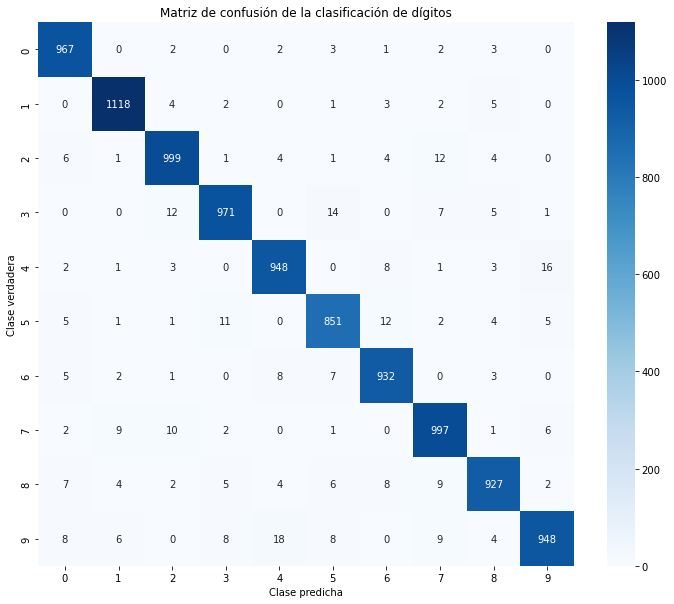

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))
matrix = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)

matrix.set_title('Matriz de confusión de la clasificación de dígitos')
matrix.set_xlabel('Clase predicha')
matrix.set_ylabel('Clase verdadera')

plt.show()